# Investigation of the behavior of users of a mobile application for the sale of food

<b> Customer: </b>

A startup based on the sale of food.

<b> Data provided: </b>

Data log containing information about:
- eventName — event name;
- DeviceIDHash — unique user ID;
- EventTimestamp — event time;
- ExpId — experiment number: 246 and 247 are control groups, and 248 is experimental.

<b> Research objectives: </b>
1. Studying the sales funnel:
- Explore the users' path to purchase;
- - Set the number of users who made a purchase and did not reach this event;
- Identify the stages at which users are "stuck".
2. Investigation of the results of the A/A/B experiment:
- To study the results of the experiment and identify, if available, patterns affecting the change in the activity of users of the experimental group with a different font.

## Data Preparation and Exploration

In [732]:
import pandas as pd
import numpy as np
from scipy import stats as st
import math as mth
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')

In [733]:
df = pd.read_csv('/Users/vintera/Git/my_projects/dataset/project_09/logs_exp.csv', sep='\t')

In [734]:
df.info()
df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


,EventName,DeviceIDHash,EventTimestamp,ExpId
64011,CartScreenAppear,674541835027541643,1564760761,248
15327,MainScreenAppear,9194161737535459139,1564657295,246
93384,MainScreenAppear,4435879673000792272,1564839621,246
10833,MainScreenAppear,8986496821481874277,1564649124,247
204851,MainScreenAppear,7524162245056732296,1565110927,247


In [735]:
df.EventName.value_counts()

MainScreenAppear           119205
OffersScreenAppear          46825
CartScreenAppear            42731
PaymentScreenSuccessful     34313
Tutorial                     1052
Name: EventName, dtype: int64

In [736]:
df.ExpId.value_counts()

248    85747
246    80304
247    78075
Name: ExpId, dtype: int64

### Summary
We have got acquainted with the data, we can start processing them.

## Data preprocessing and research

In [737]:
# For convenience, rename the columns
df = df.rename(columns={'EventName' : 'event',
                        'DeviceIDHash' : 'id',
                        'EventTimestamp' : 'dt',
                        'ExpId' : 'group'})

In [738]:
# Convert the date and time column to the appropriate format
df.dt = pd.to_datetime(df.dt, unit='s')

In [739]:
# Create a column containing only the date of the event
df['date'] = df.dt.astype('datetime64[D]')

In [740]:
# Check for duplicates and get rid of them
print('Rows duplicated: {:.0f},'.format(df.duplicated().sum()),
      'which is: {:.2%} of the total number of rows.'.format((df.duplicated().sum() / len(df))))

Rows duplicated: 413, which is: 0.17% of the total number of rows.


In [741]:
df = df.drop_duplicates().reset_index(drop=True)

In [742]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   event   243713 non-null  object        
 1   id      243713 non-null  int64         
 2   dt      243713 non-null  datetime64[ns]
 3   group   243713 non-null  int64         
 4   date    243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 9.3+ MB


#### Summary
The columns have been renamed, the date information has been adjusted to the desired format, there are no gaps and duplicates have been deleted. You can proceed to the next stage.

## Exploratory Data Analysis

In [743]:
print('Total events in the log:', df.event.count())

Total events in the log: 243713


In [744]:
print('Total users in the log:', df.id.nunique())

Total users in the log: 7551


In [745]:
print('On average, the user has', int((df.event.count() / df.id.nunique()).round()), 'события')

On average, the user has 32 события


In [746]:
print('The first date in the log:', df.dt.min())
print('Last date in the log:', df.dt.max())

The first date in the log: 2019-07-25 04:43:36
Last date in the log: 2019-08-07 21:15:17


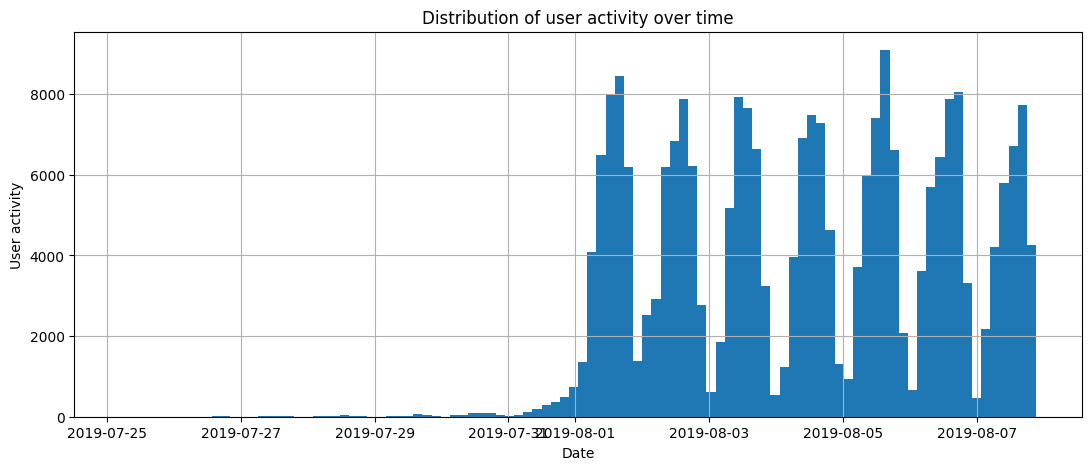

In [747]:
# Build a histogram of the distribution of user activity over time
df['dt'].hist(bins=100, figsize=(13,5))
plt.title('Distribution of user activity over time')
plt.xlabel('Date')
plt.ylabel('User activity');

In [748]:
print('95% of the data is concentrated after', df.dt.quantile(0.05))

95% of the data is concentrated after 2019-08-01 09:28:05


### Comment
As you can see on the graph, almost all data on user activity is concentrated after August 1.

In [749]:
# Create an updated dataframe containing information starting from August 1
new_df = df.query('dt > "2019-08-01 00:00:00"')

In [750]:
print('Discarding the old data, we lost', 
      df['event'].count() - new_df['event'].count(),
      'events, which is {:.2%} of the total amount of data'.format(
      ((df['event'].count() - new_df['event'].count()) / df['event'].count())))

Discarding the old data, we lost 2826 events, which is 1.16% of the total amount of data


In [751]:
print('Discarding the old data, we lost', 
      df['id'].nunique() - new_df['id'].nunique(),
      'unique users, which is {:.2%} of the total amount of data'.format(
      (df['id'].nunique() - new_df['id'].nunique()) / df['id'].nunique()))

Discarding the old data, we lost 17 unique users, which is 0.23% of the total amount of data


In [752]:
new_df.groupby('group').agg({'id':'nunique'})

,id
group,
246,2484
247,2513
248,2537


### Comment
Approximately equal number of unique users remained in all groups.

## Exploring the event funnel

In [753]:
all_events = new_df.groupby('event').agg({'id' : 'count'}).sort_values(
    by = 'id', ascending = False).reset_index()
all_events

,event,id
0,MainScreenAppear,117328
1,OffersScreenAppear,46333
2,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


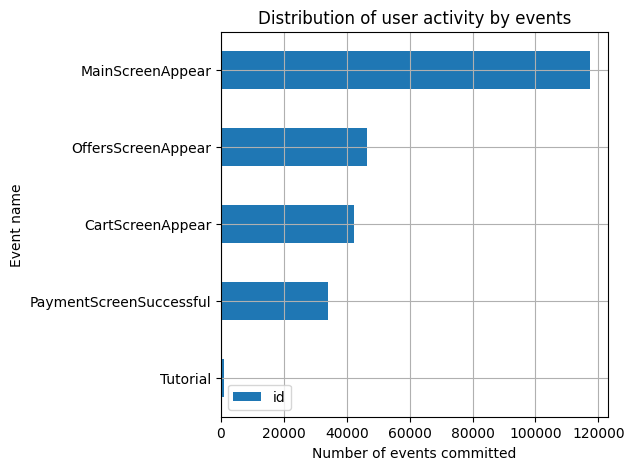

In [754]:
all_events.sort_values(by='id').plot(kind='barh', x='event', y='id', grid=True, figsize=(5,5))
plt.title('Distribution of user activity by events')
plt.xlabel('Number of events committed')
plt.ylabel('Event name');

### Comment
There are 5 types of events in the log. Starting from the most popular, it is:
 - MainScreenAppear (Home page);
 - OffersScreenAppear (Offers page);
 - CartScreenAppear (Cart page);
 - PaymentScreenSuccessful (Successful payment page);
 - Tutorial (User's Guide).

Order of events: 1. Main Screen Appears = 2. Offers Screen Appears = 3. Carp Screen Appears = 4. Payment Screen Successful 

The "Tutorial" event is usually situational, users can come to it at any stage, or they may not use it at all.

### Funnel of all users

In [755]:
# Group the number of all events by dates
users_funnel = new_df.pivot_table(
    index='date', 
    columns='event', 
    values='id',
    aggfunc='count')
users_funnel

event,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial
date,,,,,
2019-08-01 00:07:28,NaN,NaN,NaN,NaN,1.0
2019-08-01 00:08:00,NaN,1.0,NaN,NaN,NaN
2019-08-01 00:08:55,NaN,1.0,NaN,NaN,NaN
2019-08-01 00:08:58,NaN,NaN,1.0,NaN,NaN
2019-08-01 00:08:59,NaN,1.0,NaN,NaN,NaN
...,...,...,...,...,...
2019-08-07 21:12:25,NaN,1.0,NaN,NaN,NaN
2019-08-07 21:13:59,NaN,1.0,NaN,NaN,NaN
2019-08-07 21:14:43,NaN,1.0,NaN,NaN,NaN


In [756]:
# Build a graph of the funnel of events, where the values, broken down by dates, are summarized
fig = go.Figure(go.Funnel(
    y = ["Main page ",
         "Offers page", 
         "Shopping Cart page", 
         "Successful payment page"],
    x = [users_funnel.MainScreenAppear.sum(), 
         users_funnel.OffersScreenAppear.sum(), 
         users_funnel.CartScreenAppear.sum(), 
         users_funnel.PaymentScreenSuccessful.sum()]
    ))
fig.show()

#### Summary
61.5% is lost during the transition from the main page to the offers page. More than half of the users are lost at this stage. From the first event, only 28.9% of users reach payment.

### Funnel of unique users

In [757]:
print('Users who have committed at least one event:',new_df.id.nunique())

Users who have committed at least one event: 7534


In [758]:
# Create a summary table where the values will be the first dates of events committed by users
users = new_df.pivot_table(
    index='id', 
    columns='event', 
    values='dt',
    aggfunc='min').reset_index()

In [759]:
# Build a funnel and count the users who have at least once committed this or that event
fig = go.Figure(go.Funnel(
    y = ["Main page ",
         "Offers page", 
         "Shopping Cart page", 
         "Successful payment page"],
    x = [users.MainScreenAppear.count(), 
         users.OffersScreenAppear.count(), 
         users.CartScreenAppear.count(), 
         users.PaymentScreenSuccessful.count()]
    ))
fig.show()

#### Comment
Based on the calculation of the funnel of unique users, at the stage of transition from the main page to the offer page, most of the users are also lost - 38.1%. In the subsequent stages, the loss of users is not so significant.

Considering that there are 7534 unique users in total, and as we can see from the graph, only 7419 went to the main page, we can assume that at least 115 users started using the application not from the main page. Perhaps this is a feature of the application, or perhaps an error. It will be necessary to check with the customer.

In [760]:
users.query('OffersScreenAppear < MainScreenAppear')['id'].count()
users.query('CartScreenAppear < MainScreenAppear')['id'].count()
users.query('PaymentScreenSuccessful < MainScreenAppear')['id'].count()

280

203

172

#### Summary
At least 655 users start using the application not from the home screen. This fact may negatively affect the results of the study, so we will inform the data engineers, management or the customer about it. While the answer has not been received and it is unknown what actions to take, we will continue to conduct research with the available data.

### Funnel taking into account the sequence of events

In [761]:
# Calculate the number of users step by step, taking into account the sequence of events
step_1 = ~users['MainScreenAppear'].isna()
step_2 = step_1 & (users['OffersScreenAppear'] > users['MainScreenAppear'])
step_3 = step_2 & (users['CartScreenAppear'] > users['OffersScreenAppear'])
step_4 = step_3 & (users['PaymentScreenSuccessful'] > users['CartScreenAppear'])

n_main_screen = users[step_1].shape[0]
n_offer = users[step_2].shape[0]
n_cart = users[step_3].shape[0]
n_payment_successful = users[step_4].shape[0]

In [762]:
# Build a funnel in the same way
fig = go.Figure(go.Funnel(
    y = ["Main page ",
         "Offers page", 
         "Shopping Cart page", 
         "Successful payment page"],
    x = [n_main_screen, 
         n_offer, 
         n_cart, 
         n_payment_successful]
    ))
fig.show()

#### Comment
Given the sequence of events, the picture seems more disappointing. 74.3% is lost at the stage of transition from the basket to the successful payment of its contents.

Only 6.1% of users reach successful payment from the main page.

#### Summary

Having considered the funnels of events for three variations of users, first of all you should pay attention to the funnel, built taking into account the sequence of events, where at each stage of the funnel almost half of the users are eliminated, and only 454 users out of 7419 reach successful payment, which is 6.1%. When switching from shopping cart to payment for goods, the largest number of users is lost - 74.3%. It is possible in the application, at the specified stage, users have difficulties related to technical problems.

## Studying the results of the experiment

In [763]:
# Divide the users into groups and check the data for a match id
group_246 = new_df.query('group == 246')
id_246 = pd.Series(group_246['id'])

group_247 = new_df.query('group == 247')
id_247 = pd.Series(group_247['id'])

group_248 = new_df.query('group == 248')
id_248 = pd.Series(group_248['id'])

group_246.query('id in @id_247')['id'].count()
group_246.query('id in @id_248')['id'].count()
group_247.query('id in @id_248')['id'].count()
group_247.query('id in @id_246')['id'].count()
group_248.query('id in @id_246')['id'].count()
group_248.query('id in @id_247')['id'].count()

0

0

0

0

0

0

### Comment
Duplicate IDs were not detected.

In [764]:
user_groups = new_df.groupby('group').agg({'id' : 'nunique'})
user_groups

,id
group,
246,2484
247,2513
248,2537


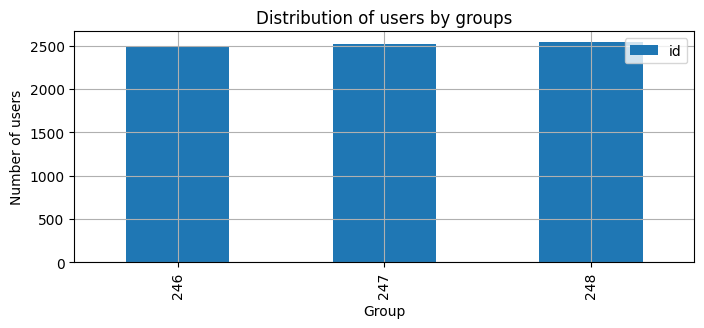

In [765]:
user_groups.plot(kind='bar', grid=True, figsize=(8,3))
plt.title('Distribution of users by groups')
plt.xlabel('Group')
plt.ylabel('Number of users');

### Comment
The number of users in groups is approximately the same.

### Hypothesis testing
Let's formulate hypotheses for the compared fractions:
    
    h₀ - There is no reason to consider the shares different.

    h₁ - There is a significant difference between the shares.

In [766]:
# Create a function where in the parameters we specify the dataset, the name of the event, the groups being compared and the alpha value
def Ztest(data, event, gr1, gr2, alpha):
    
    # Count the number of completed events and unique users in groups
    gr1_event = data.query('group == @gr1 and @event in event').id.nunique()
    gr2_event = data.query('group == @gr2 and @event in event').id.nunique()
    gr1_users = data.query('group == @gr1').id.nunique()
    gr2_users = data.query('group == @gr2').id.nunique()
    
    # Calculate the shares in the groups and the difference between them
    p1 = gr1_event / gr1_users
    p2 = gr2_event / gr2_users
    difference = p1 - p2
    
    p_combined = (gr1_event + gr2_event) / (gr1_users + gr2_users)
    
    # Calculate statistics in standard deviations of the standard normal distribution
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/gr1_users + 1/gr2_users))
    
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('Event: {}'.format(event))
    print('Groups being compared: {}, {}'.format(gr1, gr2))
    print('------------------------------')
    print('p-value: ', round(p_value, 5))
    
    if p_value < alpha:
        print('Reject the null hypothesis: there is a significant difference between the shares')
    else:
        print('Not possible to reject the null hypothesis, there is no reason to consider the shares different') 

In [767]:
Ztest(new_df, 'MainScreenAppear', 246, 247, 0.05)

Event: MainScreenAppear
Groups being compared: 246, 247
------------------------------
p-value:  0.75706
Not possible to reject the null hypothesis, there is no reason to consider the shares different


#### Summary
The difference in statistical criteria between samples 246 and 247 in the "Home page" event was not revealed.

In [768]:
# Divide the events into groups and calculate the shares for each
popular_event = new_df.pivot_table(
        index='group', 
        columns='event', 
        values='id',
        aggfunc='nunique').reset_index()

popular_event['total'] = popular_event[['Tutorial', 
                               'MainScreenAppear', 
                               'OffersScreenAppear', 
                               'CartScreenAppear',
                               'PaymentScreenSuccessful']].sum(axis=1)
popular_event['tutorial_ratio'] = (popular_event['Tutorial'] / popular_event['total']).round(3)
popular_event['main_ratio'] = (popular_event['MainScreenAppear'] / popular_event['total']).round(3)
popular_event['offer_ratio'] = (popular_event['OffersScreenAppear'] / popular_event['total']).round(3)
popular_event['cart_ratio'] = (popular_event['CartScreenAppear'] / popular_event['total']).round(3)
popular_event['payment_ratio'] = (popular_event['PaymentScreenSuccessful'] / popular_event['total']).round(3)

popular_event = popular_event[['group',
                               'total',
                               'Tutorial',
                               'tutorial_ratio',
                               'MainScreenAppear',
                               'main_ratio',
                               'OffersScreenAppear',
                               'offer_ratio',
                               'CartScreenAppear',
                               'cart_ratio',
                               'PaymentScreenSuccessful',
                               'payment_ratio']]
popular_event

event,group,total,Tutorial,tutorial_ratio,MainScreenAppear,main_ratio,OffersScreenAppear,offer_ratio,CartScreenAppear,cart_ratio,PaymentScreenSuccessful,payment_ratio
0,246,6736,278,0.041,2450,0.364,1542,0.229,1266,0.188,1200,0.178
1,247,6675,283,0.042,2476,0.371,1520,0.228,1238,0.185,1158,0.173
2,248,6714,279,0.042,2493,0.371,1531,0.228,1230,0.183,1181,0.176


#### Summary
The most popular event for all groups will be the transition to the main screen. The shares between the groups are approximately equal.

#### Comparison of control groups 246 and 247

In [769]:
print('1.')
Ztest(new_df, 'MainScreenAppear', 246, 247, 0.05)
print('2.')
Ztest(new_df, 'OffersScreenAppear', 246, 247, 0.05)
print('3.')
Ztest(new_df, 'CartScreenAppear', 246, 247, 0.05)
print('4.')
Ztest(new_df, 'PaymentScreenSuccessful', 246, 247, 0.05)
print('5.')
Ztest(new_df, 'Tutorial', 246, 247, 0.05)

1.
Event: MainScreenAppear
Groups being compared: 246, 247
------------------------------
p-value:  0.75706
Not possible to reject the null hypothesis, there is no reason to consider the shares different
2.
Event: OffersScreenAppear
Groups being compared: 246, 247
------------------------------
p-value:  0.2481
Not possible to reject the null hypothesis, there is no reason to consider the shares different
3.
Event: CartScreenAppear
Groups being compared: 246, 247
------------------------------
p-value:  0.22883
Not possible to reject the null hypothesis, there is no reason to consider the shares different
4.
Event: PaymentScreenSuccessful
Groups being compared: 246, 247
------------------------------
p-value:  0.11457
Not possible to reject the null hypothesis, there is no reason to consider the shares different
5.
Event: Tutorial
Groups being compared: 246, 247
------------------------------
p-value:  0.9377
Not possible to reject the null hypothesis, there is no reason to consider th

##### Summary
Based on the results of the tests carried out, it can be assumed that the division into groups works correctly.

#### Comparison of control groups 246, 247 with experimental 248

In [770]:
print('1.')
Ztest(new_df, 'MainScreenAppear', 246, 248, 0.05)
print('2.')
Ztest(new_df, 'OffersScreenAppear', 246, 248, 0.05)
print('3.')
Ztest(new_df, 'CartScreenAppear', 246, 248, 0.05)
print('4.')
Ztest(new_df, 'PaymentScreenSuccessful', 246, 248, 0.05)
print('5.')
Ztest(new_df, 'Tutorial', 246, 248, 0.05)

1.
Event: MainScreenAppear
Groups being compared: 246, 248
------------------------------
p-value:  0.29497
Not possible to reject the null hypothesis, there is no reason to consider the shares different
2.
Event: OffersScreenAppear
Groups being compared: 246, 248
------------------------------
p-value:  0.20836
Not possible to reject the null hypothesis, there is no reason to consider the shares different
3.
Event: CartScreenAppear
Groups being compared: 246, 248
------------------------------
p-value:  0.07843
Not possible to reject the null hypothesis, there is no reason to consider the shares different
4.
Event: PaymentScreenSuccessful
Groups being compared: 246, 248
------------------------------
p-value:  0.21226
Not possible to reject the null hypothesis, there is no reason to consider the shares different
5.
Event: Tutorial
Groups being compared: 246, 248
------------------------------
p-value:  0.82643
Not possible to reject the null hypothesis, there is no reason to consider 

In [771]:
print('1.')
Ztest(new_df, 'MainScreenAppear', 247, 248, 0.05)
print('2.')
Ztest(new_df, 'OffersScreenAppear', 247, 248, 0.05)
print('3.')
Ztest(new_df, 'CartScreenAppear', 247, 248, 0.05)
print('4.')
Ztest(new_df, 'PaymentScreenSuccessful', 247, 248, 0.05)
print('5.')
Ztest(new_df, 'Tutorial', 247, 248, 0.05)

1.
Event: MainScreenAppear
Groups being compared: 247, 248
------------------------------
p-value:  0.45871
Not possible to reject the null hypothesis, there is no reason to consider the shares different
2.
Event: OffersScreenAppear
Groups being compared: 247, 248
------------------------------
p-value:  0.91978
Not possible to reject the null hypothesis, there is no reason to consider the shares different
3.
Event: CartScreenAppear
Groups being compared: 247, 248
------------------------------
p-value:  0.57862
Not possible to reject the null hypothesis, there is no reason to consider the shares different
4.
Event: PaymentScreenSuccessful
Groups being compared: 247, 248
------------------------------
p-value:  0.73734
Not possible to reject the null hypothesis, there is no reason to consider the shares different
5.
Event: Tutorial
Groups being compared: 247, 248
------------------------------
p-value:  0.76532
Not possible to reject the null hypothesis, there is no reason to consider 

##### Summary
There are no statistically significant differences between the control groups and the group with the changed font.

#### Comparison of the combined control group with the experimental one

In [772]:
pooled_control_group = new_df.copy()

In [773]:
pooled_control_group.group = pooled_control_group.group.replace({246: 493, 247: 493})
# Let's call the combined control group - 493

In [774]:
print('1.')
Ztest(pooled_control_group, 'MainScreenAppear', 493, 248, 0.05)
print('2.')
Ztest(pooled_control_group, 'OffersScreenAppear', 493, 248, 0.05)
print('3.')
Ztest(pooled_control_group, 'CartScreenAppear', 493, 248, 0.05)
print('4.')
Ztest(pooled_control_group, 'PaymentScreenSuccessful', 493, 248, 0.05)
print('5.')
Ztest(pooled_control_group, 'Tutorial', 493, 248, 0.05)

1.
Event: MainScreenAppear
Groups being compared: 493, 248
------------------------------
p-value:  0.29425
Not possible to reject the null hypothesis, there is no reason to consider the shares different
2.
Event: OffersScreenAppear
Groups being compared: 493, 248
------------------------------
p-value:  0.43426
Not possible to reject the null hypothesis, there is no reason to consider the shares different
3.
Event: CartScreenAppear
Groups being compared: 493, 248
------------------------------
p-value:  0.18176
Not possible to reject the null hypothesis, there is no reason to consider the shares different
4.
Event: PaymentScreenSuccessful
Groups being compared: 493, 248
------------------------------
p-value:  0.60043
Not possible to reject the null hypothesis, there is no reason to consider the shares different
5.
Event: Tutorial
Groups being compared: 493, 248
------------------------------
p-value:  0.76486
Not possible to reject the null hypothesis, there is no reason to consider 

##### Summary
When comparing the combined control group and the experimental group with a modified font, there are also no differences between them. 

In total, 20 tests were conducted, according to the results of which it was not possible to refute the null hypothesis, there are no grounds to consider the shares different. For the tests, a significance level of 0.05 was used, that is, every twentieth time it was possible to get a false result. It is impractical to change the significance level and conduct new tests, since the p-values in the tests performed were almost always quite high, which indicates the accuracy of the experimental results.

## General Conclusion and Recommendations

Summing up the research and answering the questions of the tasks, we can draw the following conclusions:

<b>1. Sales funnel:</b>
- When using the application, users usually observe the following order of events: Main Screen Appear → Offers Screen Appear → Cart Screen Appear → Payment Screen Successful. The Tutorial event is held by users at their discretion;
- Out of 7419 unique users who visited the main page, only 454 users reached the successful purchase, observing the logic of event execution. That is, 6965 (93.9%) of users who visited the main page dropped out without making a purchase, which indicates extremely weak sales figures.;
- Most of the users are cut off after viewing the main page, which can be explained by the lack of interest in the products presented. However, you should pay close attention to 74.3% of users who chose the product they were interested in, went to the shopping cart to make a purchase, but never made a payment. It can be assumed that some people change their mind about making a purchase after seeing the total amount or for other reasons, but a high percentage of such users suggests that this is not the only reason for refusing to make a payment and may be due to difficulties or technical errors in the application when making a payment.

<b>2. Investigation of the results of the A/A/B experiment:</b>
- The recruitment into the groups was made correctly - the number of users is distributed almost equally, they do not repeat among the groups, and the conducted testing found that there are no statistically significant differences in the two control groups.
- When conducting comparative tests of control groups, as well as their combined version with the experimental group, no statistically significant differences were found. The changed font in the experimental group does not affect user activity in any way.